<a href="https://colab.research.google.com/github/mkhural/W266_Final_Project/blob/main/W266_GRUEN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Make sure './cola_model/bert-base-cased' files uploaded


In [ ]:
!pip install -r requirements.txt

In [ ]:
!python -m spacy download en_core_web_md

In [32]:
#!pip install wmd==1.3.1
import Main

In [ ]:
# If pytoch model doesn't run:
# !pip install transformers==2.8.0

In [33]:
#import nltk
#nltk.download('punkt')
import cdifflib
import editdistance
import math
import numpy as np
import re
import spacy
import string
import torch
from nltk.tokenize import sent_tokenize
from tqdm import tqdm
from transformers import BertConfig, BertForSequenceClassification, BertTokenizer, BertForMaskedLM
from transformers import glue_convert_examples_to_features
from transformers.data.processors.utils import InputExample
from wmd import WMD

In [34]:
candidates = ["This is a good example.",
                  "This is a bad example. It is ungrammatical and redundant. Orellana shown red card for throwing grass at Sergio Busquets. Orellana shown red card for throwing grass at Sergio Busquets."]
gruen_output = Main.get_gruen(candidates)
print(gruen_output)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).

100%|██████████| 2/2 [00:00<00:00, 43.97it/s]

Evaluating: 100%|██████████| 5/5 [00:00<00:00, 116.91it/s]


[0.8277465403079987, 0.01946841925382889]


In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


""" Processing """
def preprocess_candidates(candidates):
    for i in range(len(candidates)):
        candidates[i] = candidates[i].strip()
        candidates[i] = '. '.join(candidates[i].split('\n\n'))
        candidates[i] = '. '.join(candidates[i].split('\n'))
        candidates[i] = '.'.join(candidates[i].split('..'))
        candidates[i] = '. '.join(candidates[i].split('.'))
        candidates[i] = '. '.join(candidates[i].split('. . '))
        candidates[i] = '. '.join(candidates[i].split('.  . '))
        while len(candidates[i].split('  ')) > 1:
            candidates[i] = ' '.join(candidates[i].split('  '))
        myre = re.search(r'(\d+)\. (\d+)', candidates[i])
        while myre:
            candidates[i] = 'UNK'.join(candidates[i].split(myre.group()))
            myre = re.search(r'(\d+)\. (\d+)', candidates[i])
        candidates[i] = candidates[i].strip()
    processed_candidates = []
    for candidate_i in candidates:
        sentences = sent_tokenize(candidate_i)
        out_i = []
        for sentence_i in sentences:
            if len(sentence_i.translate(str.maketrans('', '', string.punctuation)).split()) > 1:  # More than one word.
                out_i.append(sentence_i)
        processed_candidates.append(out_i)
    return processed_candidates


""" Scores Calculation """
def get_lm_score(sentences):
    def score_sentence(sentence, tokenizer, model):
        # if len(sentence.strip().split()) <= 1:
        #     return 10000
        tokenize_input = tokenizer.tokenize(sentence)
        if len(tokenize_input) > 510:
            tokenize_input = tokenize_input[:510]
        input_ids = torch.tensor(tokenizer.encode(tokenize_input)).unsqueeze(0).to(device)
        with torch.no_grad():
            loss = model(input_ids, labels=input_ids)[0]
        return math.exp(loss.item())

    model_name = 'bert-base-cased'
    model = BertForMaskedLM.from_pretrained(model_name).to(device)
    model.eval()
    tokenizer = BertTokenizer.from_pretrained(model_name)
    lm_score = []
    for sentence in tqdm(sentences):
        if len(sentence) == 0:
            lm_score.append(0.0)
            continue
        score_i = 0.0
        for x in sentence:
            score_i += score_sentence(x, tokenizer, model)
        score_i /= len(sentence)
        lm_score.append(score_i)
    return lm_score


def get_cola_score(sentences):
    def load_pretrained_cola_model(model_name, saved_pretrained_CoLA_model_dir):
        config_class, model_class, tokenizer_class = (BertConfig, BertForSequenceClassification, BertTokenizer)
        config = config_class.from_pretrained(saved_pretrained_CoLA_model_dir, num_labels=2, finetuning_task='CoLA')
        tokenizer = tokenizer_class.from_pretrained(saved_pretrained_CoLA_model_dir, do_lower_case=0)
        model = model_class.from_pretrained(saved_pretrained_CoLA_model_dir, from_tf=bool('.ckpt' in model_name), config=config).to(device)
        model.eval()
        return tokenizer, model

    def evaluate_cola(model, candidates, tokenizer, model_name):

        def load_and_cache_examples(candidates, tokenizer):
            max_length = 128
            examples = [InputExample(guid=str(i), text_a=x) for i,x in enumerate(candidates)]
            features = glue_convert_examples_to_features(examples, tokenizer, label_list=["0", "1"], max_length=max_length, output_mode="classification")
            # Convert to Tensors and build dataset
            all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
            all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
            all_labels = torch.tensor([0 for f in features], dtype=torch.long)
            all_token_type_ids = torch.tensor([[0.0]*max_length for f in features], dtype=torch.long)
            dataset = torch.utils.data.TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
            return dataset

        eval_dataset = load_and_cache_examples(candidates, tokenizer)
        eval_dataloader = torch.utils.data.DataLoader(eval_dataset, sampler=torch.utils.data.SequentialSampler(eval_dataset), batch_size=max(1, torch.cuda.device_count()))
        preds = None
        for batch in tqdm(eval_dataloader, desc="Evaluating"):
            model.eval()
            batch = tuple(t.to(device) for t in batch)

            with torch.no_grad():
                inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[3]}
                if model_name.split('-')[0] != 'distilbert':
                    inputs['token_type_ids'] = batch[2] if model_name.split('-')[0] in ['bert', 'xlnet'] else None  # XLM, DistilBERT and RoBERTa don't use segment_ids
                outputs = model(**inputs)
                tmp_eval_loss, logits = outputs[:2]

            if preds is None:
                preds = logits.detach().cpu().numpy()
            else:
                preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
        return preds[:, 1].tolist()

    def convert_sentence_score_to_paragraph_score(sentence_score, sent_length):
        paragraph_score = []
        pointer = 0
        for i in sent_length:
            if i == 0:
                paragraph_score.append(0.0)
                continue
            temp_a = sentence_score[pointer:pointer + i]
            paragraph_score.append(sum(temp_a) / len(temp_a))
            pointer += i
        return paragraph_score

    model_name = 'bert-base-cased'
    saved_pretrained_CoLA_model_dir = './cola_model/' + model_name + '/'
    tokenizer, model = load_pretrained_cola_model(model_name, saved_pretrained_CoLA_model_dir)
    candidates = [y for x in sentences for y in x]
    sent_length = [len(x) for x in sentences]
    cola_score = evaluate_cola(model, candidates, tokenizer, model_name)
    cola_score = convert_sentence_score_to_paragraph_score(cola_score, sent_length)
    return cola_score


def get_grammaticality_score(processed_candidates):
    lm_score = get_lm_score(processed_candidates)
    cola_score = get_cola_score(processed_candidates)
    grammaticality_score = [1.0 * math.exp(-0.5*x) + 1.0 * y for x, y in zip(lm_score, cola_score)]
    grammaticality_score = [max(0, x / 8.0 + 0.5) for x in grammaticality_score]  # re-scale
    return grammaticality_score


def get_redundancy_score(all_summary):
    def if_two_sentence_redundant(a, b):
        """ Determine whether there is redundancy between two sentences. """
        if a == b:
            return 4
        if (a in b) or (b in a):
            return 4
        flag_num = 0
        a_split = a.split()
        b_split = b.split()
        if max(len(a_split), len(b_split)) >= 5:
            longest_common_substring = cdifflib.CSequenceMatcher(None, a, b).find_longest_match(0, len(a), 0, len(b))
            LCS_string_length = longest_common_substring.size
            if LCS_string_length > 0.8 * min(len(a), len(b)):
                flag_num += 1
            LCS_word_length = len(a[longest_common_substring[0]: (longest_common_substring[0]+LCS_string_length)].strip().split())
            if LCS_word_length > 0.8 * min(len(a_split), len(b_split)):
                flag_num += 1
            edit_distance = editdistance.eval(a, b)
            if edit_distance < 0.6 * max(len(a), len(b)):  # Number of modifications from the longer sentence is too small.
                flag_num += 1
            number_of_common_word = len([x for x in a_split if x in b_split])
            if number_of_common_word > 0.8 * min(len(a_split), len(b_split)):
                flag_num += 1
        return flag_num

    redundancy_score = [0.0 for x in range(len(all_summary))]
    for i in range(len(all_summary)):
        flag = 0
        summary = all_summary[i]
        if len(summary) == 1:
            continue
        for j in range(len(summary) - 1):  # for pairwise redundancy
            for k in range(j + 1, len(summary)):
                flag += if_two_sentence_redundant(summary[j].strip(), summary[k].strip())
        redundancy_score[i] += -0.1 * flag
    return redundancy_score


def get_focus_score(all_summary):
    def compute_sentence_similarity():
        nlp = spacy.load('en_core_web_md')
        nlp.add_pipe(WMD.SpacySimilarityHook(nlp), last=True)
        all_score = []
        for i in range(len(all_summary)):
            if len(all_summary[i]) == 1:
                all_score.append([1.0])
                continue
            score = []
            for j in range(1, len(all_summary[i])):
                doc1 = nlp(all_summary[i][j-1])
                doc2 = nlp(all_summary[i][j])
                try:
                    score.append(1.0/(1.0 + math.exp(-doc1.similarity(doc2)+7)))
                except:
                    score.append(1.0)
            all_score.append(score)
        return all_score

    all_score = compute_sentence_similarity()
    focus_score = [0.0 for x in range(len(all_summary))]
    for i in range(len(all_score)):
        if len(all_score[i]) == 0:
            continue
        if min(all_score[i]) < 0.05:
            focus_score[i] -= 0.1
    return focus_score

## Altered script to return all component scores of gruen
def get_gruen(candidates):
    processed_candidates = preprocess_candidates(candidates)
    grammaticality_score = get_grammaticality_score(processed_candidates)
    redundancy_score = get_redundancy_score(processed_candidates)
    focus_score = get_focus_score(processed_candidates)
    component_scores = [zip(grammaticality_score, redundancy_score, focus_score)]
    gruen_score = [min(1, max(0, sum(i))) for i in zip(grammaticality_score, redundancy_score, focus_score)]
    gruen_output = [list(a) for a in zip(gruen_score,grammaticality_score, redundancy_score, focus_score)]
    return gruen_output


if __name__ == "__main__":
    candidates = ["This is a good example.",
                  "This is a bad example. It is ungrammatical and redundant. Orellana shown red card for throwing grass at Sergio Busquets. Orellana shown red card for throwing grass at Sergio Busquets."]
    gruen_score = get_gruen(candidates)
    print(gruen_score)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).

100%|██████████| 2/2 [00:00<00:00, 47.76it/s]

Evaluating: 100%|██████████| 5/5 [00:00<00:00, 113.37it/s]


[[0.8277465403079987, 0.8277465403079987, 0.0, 0.0], [0.01946841925382889, 0.5194684192538289, -0.4, -0.1]]


In [ ]:
import os
import sys
import requests
from tqdm import tqdm

subdir = 'data'
if not os.path.exists(subdir):
    os.makedirs(subdir)
subdir = subdir.replace('\\','/') # needed for Windows

for ds in [
    'webtext',
    'small-117M', 
    'medium-345M',
    'large-762M', 
    'xl-1542M'
]:
#    for split in ['train', 'valid', 'test']:
    for split in ['test']:
        filename = ds + "." + split + '.jsonl'
        r = requests.get("https://openaipublic.azureedge.net/gpt-2/output-dataset/v1/" + filename, stream=True)

        with open(os.path.join(subdir, filename), 'wb') as f:
            file_size = int(r.headers["content-length"])
            chunk_size = 1000
            with tqdm(ncols=100, desc="Fetching " + filename, total=file_size, unit_scale=True) as pbar:
                # 1k for chunk_size, since Ethernet packet size is around 1500 bytes
                for chunk in r.iter_content(chunk_size=chunk_size):
                    f.write(chunk)
                    pbar.update(chunk_size)

Fetching webtext.train.jsonl: 679Mit [02:04, 5.44Mit/s]                                             
Fetching webtext.valid.jsonl: 13.6Mit [00:02, 6.46Mit/s]                                            
Fetching webtext.test.jsonl: 13.5Mit [00:01, 7.24Mit/s]                                             
Fetching small-117M.train.jsonl: 775Mit [01:57, 6.59Mit/s]                                          
Fetching small-117M.valid.jsonl: 15.4Mit [00:01, 11.2Mit/s]                                         
Fetching small-117M.test.jsonl: 15.6Mit [00:01, 14.1Mit/s]                                          
Fetching small-117M-k40.train.jsonl: 711Mit [02:08, 5.53Mit/s]                                      
Fetching small-117M-k40.valid.jsonl: 14.4Mit [00:01, 8.90Mit/s]                                     
Fetching small-117M-k40.test.jsonl: 14.4Mit [00:02, 5.71Mit/s]                                      
Fetching medium-345M.train.jsonl: 791Mit [02:24, 5.49Mit/s]                                

In [ ]:
import json
import pandas as pd

In [ ]:
data = []
with open('/content/data/webtext.test.jsonl') as f:
    for line in f:
      data.append(json.loads(line))
web=pd.DataFrame(data)
web=web.sample(frac=0.2, replace=False, random_state=1)

data = []
with open('/content/data/small-117M.test.jsonl') as f:
    for line in f:
      data.append(json.loads(line))
sml=pd.DataFrame(data)
sml=sml.sample(frac=0.2, replace=False, random_state=1)

data = []
with open('/content/data/medium-345M.test.jsonl') as f:
    for line in f:
      data.append(json.loads(line))
med=pd.DataFrame(data)
med=med.sample(frac=0.2, replace=False, random_state=1)

data = []
with open('/content/data/large-762M.test.jsonl') as f:
    for line in f:
      data.append(json.loads(line))
lrg=pd.DataFrame(data)
lrg=lrg.sample(frac=0.2, replace=False, random_state=1)

data = []
with open('/content/data/xl-1542M.test.jsonl') as f:
    for line in f:
      data.append(json.loads(line))
xl=pd.DataFrame(data)
xl=xl.sample(frac=0.2, replace=False, random_state=1)
#make web, small, med, lrg, xl dataframes of 1000 records each for metric output speed

In [ ]:
web_gruen_input = web['text'].to_list()
sml_gruen_input = sml['text'].to_list()
med_gruen_input = med['text'].to_list()
lrg_gruen_input = lrg['text'].to_list()
xl_gruen_input = xl['text'].to_list()

In [ ]:
candidates = web_gruen_input
web_g_score = get_gruen(candidates)

In [48]:
#web_df = pd.DataFrame(web_g_score, columns = ['gruen','grammaticality','redundancy','focus'])
#web_df.head()
#web.reset_index(drop=True, inplace=True)
#web_base=web.join(web_df)
#web_base.head()
web_base.to_csv('web_base.csv',index=False)

In [49]:
candidates = sml_gruen_input
sml_g_score = get_gruen(candidates)
sml_df = pd.DataFrame(sml_g_score, columns = ['gruen','grammaticality','redundancy','focus'])
sml.reset_index(drop=True, inplace=True)
sml_base=sml.join(sml_df)
sml_base.to_csv('sml_base.csv',index=False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).

100%|██████████| 1000/1000 [03:17<00:00,  5.06it/s]

Evaluating: 100%|██████████| 24541/24541 [03:35<00:00, 113.91it/s]
/usr/local/lib/python3.7/dist-packages/wmd/__init__.py:668: RuntimeWarning: invalid value encountered in true_divide
  w /= w.sum()


In [52]:
web_base.describe()

,id,length,gruen,grammaticality,redundancy,focus
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,257475.078000,579.282000,0.461587,0.733437,-1.476600,-0.024800
std,1441.114109,351.542989,0.311562,0.070516,14.352145,0.043207
min,255005.000000,43.000000,0.000000,0.410633,-419.700000,-0.100000
25%,256254.000000,257.750000,0.054439,0.696490,-0.600000,0.000000
50%,257452.000000,547.000000,0.587024,0.744291,-0.100000,0.000000
75%,258730.500000,1024.000000,0.727424,0.785078,0.000000,0.000000
max,259997.000000,1024.000000,0.880959,0.880959,0.000000,0.000000


In [53]:
sml_base.describe()

,id,length,gruen,grammaticality,redundancy,focus
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,257476.078000,663.073000,0.442810,0.601027,-3.993700,-0.013700
std,1441.114109,382.680695,0.243402,0.096127,99.633897,0.034402
min,255006.000000,0.000000,0.000000,0.258101,-3138.800000,-0.100000
25%,256255.000000,269.000000,0.297803,0.539403,-0.200000,0.000000
50%,257453.000000,797.000000,0.510284,0.606247,0.000000,0.000000
75%,258731.500000,1024.000000,0.629475,0.666563,0.000000,0.000000
max,259998.000000,1024.000000,0.881081,0.881081,0.000000,0.000000


In [84]:
# Web num gruen = 0
print((web_base['gruen']==0).sum()/1000)
# Small Model num gruen = 0 
print((sml_base['gruen']==0).sum()/1000)

0.236
0.138


In [51]:
import matplotlib.pyplot as plt
import numpy

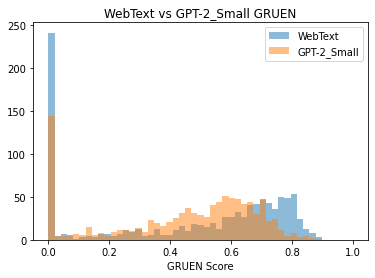

In [94]:
bins = numpy.linspace(0, 1, 50)

plt.hist(web_base['gruen'], bins, alpha=0.5, label='WebText')
plt.hist(sml_base['gruen'], bins, alpha=0.5, label='GPT-2_Small')
plt.title('WebText vs GPT-2_Small GRUEN')
plt.xlabel('GRUEN Score')
plt.legend(loc='upper right')
plt.show()

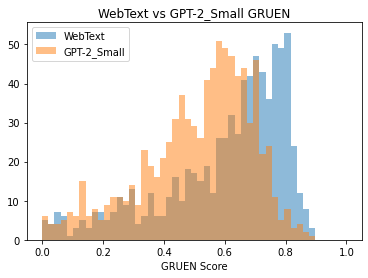

In [93]:
bins = numpy.linspace(0.00001, 1, 50)

plt.hist(web_base['gruen'], bins, alpha=0.5, label='WebText')
plt.hist(sml_base['gruen'], bins, alpha=0.5, label='GPT-2_Small')
plt.title('WebText vs GPT-2_Small GRUEN')
plt.xlabel('GRUEN Score')
plt.legend(loc='upper left')
plt.show()
## Plot after taking 100

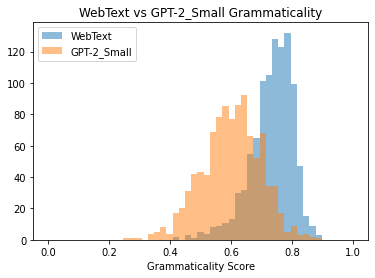

In [95]:
bins = numpy.linspace(0, 1, 50)

plt.hist(web_base['grammaticality'], bins, alpha=0.5, label='WebText')
plt.hist(sml_base['grammaticality'], bins, alpha=0.5, label='GPT-2_Small')
plt.title('WebText vs GPT-2_Small Grammaticality')
plt.xlabel('Grammaticality Score')
plt.legend(loc='upper left')
plt.show()

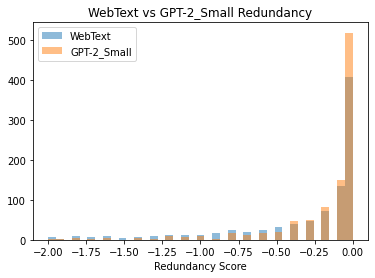

In [101]:
bins = numpy.linspace(-2, 0, 40)

plt.hist(web_base['redundancy'], bins, alpha=0.5, label='WebText')
plt.hist(sml_base['redundancy'], bins, alpha=0.5, label='GPT-2_Small')
plt.title('WebText vs GPT-2_Small Redundancy')
plt.xlabel('Redundancy Score')
plt.legend(loc='upper left')
plt.show()

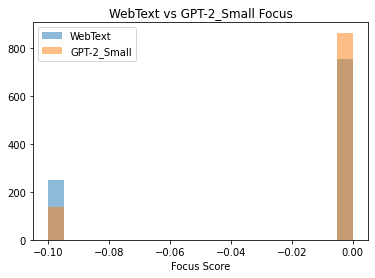

In [104]:
bins = numpy.linspace(-.1, 0, 20)

plt.hist(web_base['focus'], bins, alpha=0.5, label='WebText')
plt.hist(sml_base['focus'], bins, alpha=0.5, label='GPT-2_Small')
plt.title('WebText vs GPT-2_Small Focus')
plt.xlabel('Focus Score')
plt.legend(loc='upper left')
plt.show()

In [105]:
web_base['real'] = 1

In [106]:
sml_base['real'] = 0

In [107]:
labeled_base = pd.concat([web_base, sml_base], ignore_index=True)

In [108]:
y=labeled_base['real']
#cols = ['gruen']
X=labeled_base['gruen']

import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Optimization terminated successfully.
         Current function value: 0.692991
         Iterations 3
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.000    
Dependent Variable: real             AIC:              2773.9649
Date:               2021-08-01 05:12 BIC:              2779.5658
No. Observations:   2000             Log-Likelihood:   -1386.0  
Df Model:           0                LL-Null:          -1386.3  
Df Residuals:       1999             LLR p-value:      nan      
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     3.0000                                      
------------------------------------------------------------------
            Coef.    Std.Err.     z      P>|z|     [0.025   0.975]
------------------------------------------------------------------
gruen       0.0664     0.0841   0.7897   0.4297   -0.0985   0.2314



In [109]:
y=labeled_base['real']
cols = ['grammaticality','redundancy','focus']
X=labeled_base[cols]

import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.683436
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.014     
Dependent Variable: real             AIC:              2739.7447 
Date:               2021-08-01 05:13 BIC:              2756.5474 
No. Observations:   2000             Log-Likelihood:   -1366.9   
Df Model:           2                LL-Null:          -1386.3   
Df Residuals:       1997             LLR p-value:      3.6740e-09
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
grammaticality     0.1577   0.0736  2.1417 0.0322  0.0134  0.3021
redundancy         0.0012   0.0015  0.8011 0.4231 -0.0018  0.0043


In [125]:
list(web_base['text'].loc[web_base['redundancy']< -100])
# Legal document
# Bad Webscrape

["Still loading...\n\nA B C D E F G H I J K L M N O P Q R S T U V W X Y Z AA AB AC AD AE AF AG AH AI AJ AK AL AM 1 Inputs Conclusion Closing costs overview Suggested 2 Common (Suggested) Input rent: 8,000 kr. State fees, can't be negotiated Registration of deed (fixed cost part) 1,660 kr. 1,660 kr. 3 Investment growth 6% 6% The actual cost of owning over this period corresponds to a monthly rent of 8,800 kr. If you add the opportunity cost (that is if you invest the downpayment in stock and keep investing the difference in monthly costs) then the costs of owning corresponds to a monthly rent of 11,400 kr.. Finally if you consider buying vs. renting at 8,000 kr. per month then BUYING potentially saves you 1877000 kr. over 15 years. Registration of deed (0.6%) 15,000 kr. 15,000 kr. 4 Home apreciation 1% 1% Registration of mortgage (fixed cost part) 1,660 kr. 1,660 kr. 5 Length of stay (in years) 15 15 Registration of mortgage (1.5%) 30,000 kr. 30,000 kr. 6 Registration of bank loan (fixe

In [124]:
list(sml_base['text'].loc[sml_base['redundancy']< -100])
# Appropriately broken; medical notes

['17:47:59 - UID: 698630 Type: buy Currency: USD BTC: 16.30239489 Fiat: 14980.64\n\n17:47:59 - UID: 698630 Type: buy Currency: USD BTC: 14.87646125 Fiat: 17993.27\n\n17:47:59 - UID: 698630 Type: buy Currency: USD BTC: 82.72136294 Fiat: 23709.02\n\n17:47:59 - UID: 698630 Type: buy Currency: USD BTC: 16.086485 Fiat: 14432.31\n\n17:47:59 - UID: 698630 Type: buy Currency: USD BTC: 11.676733265 Fiat: 14877.99\n\n17:47:59 - UID: 698630 Type: buy Currency: USD BTC: 13.739301208 Fiat: 15414.66\n\n17:47:59 - UID: 698630 Type: buy Currency: USD BTC: 34.3291853 Fiat: 4109.20\n\n17:47:60 - UID: 698630 Type: buy Currency: USD BTC: 400.58233633 Fiat: 7132.58\n\n17:47:60 - UID: 698630 Type: buy Currency: USD BTC: 300.00692843 Fiat: 27961.77\n\n17:47:60 - UID: 698630 Type: buy Currency: USD BTC: 469.88147240 Fiat: 53944.72\n\n17:47:60 - UID: 698630 Type: buy Currency: USD BTC: 902.72796199 Fiat: 17705.00\n\n17:47:60 - UID: 698630 Type: buy Currency: USD BTC: 47.519752375 Fiat: 57660.94\n\n17:47:60 - U